<a href="https://colab.research.google.com/github/TaufiqIdrus/Aplikasi-Pendeteksi-Mobil-master/blob/master/Iterasi%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Identifikasi Penyakit Pada Tanaman Apel menggunakan Convolutional Neural Network**

In [1]:
import numpy as np
import pickle
import os
import cv2
import tensorflow as tf
import keras
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.normalization import batch_normalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from numpy import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, recall_score


Importing and Preparing Dataset

In [2]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/Fold 1.rar').extractall('/content/Datasets/')
iterasi = 1
width=256
height=256
default_image_size = tuple((height, width))
directory_root_train = '/content/Datasets/Fold 1/Train'
directory_root_validation = '/content/Datasets/Fold 1/Validation'
directory_root_test = '/content/Datasets/Fold 1/Test'
image_size = 0
depth=3

     |████████████████████████████████| 77 kB 2.8 MB/s 


In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return keras.preprocessing.image.img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Converting **Training** Data to Array

In [4]:
image_list_train, label_list_train = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root_train)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root_train}/{plant_disease_folder}/")
      
        for image in plant_disease_image_list:
            image_directory = f"{directory_root_train}/{plant_disease_folder}/{image}"

            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list_train.append(convert_image_to_array(image_directory))
                label_list_train.append(plant_disease_folder)
    print("[INFO] Image loading completed")

except Exception as e:
    print(f"Error : {e}")

#image labeling
image_size = len(image_list_train)
label_binarizer = LabelBinarizer()
image_labels_train = label_binarizer.fit_transform(label_list_train)
pickle.dump(label_binarizer,open('label_transform_train.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
np_image_list_train = np.array(image_list_train, dtype=np.float16) / 255.0

[INFO] Loading images ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Image loading completed


Converting **Validation** Data to Array

In [5]:
image_list_validation, label_list_validation = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root_validation)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root_validation}/{plant_disease_folder}/")
      
        for image in plant_disease_image_list:
            image_directory = f"{directory_root_validation}/{plant_disease_folder}/{image}"

            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list_validation.append(convert_image_to_array(image_directory))
                label_list_validation.append(plant_disease_folder)
    print("[INFO] Image loading completed")

except Exception as e:
    print(f"Error : {e}")

#image labeling
image_size = len(image_list_validation)
label_binarizer = LabelBinarizer()
image_labels_validation = label_binarizer.fit_transform(label_list_validation)
pickle.dump(label_binarizer,open('label_transform_validation.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
np_image_list_validation = np.array(image_list_validation, dtype=np.float16) / 255.0

[INFO] Loading images ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Image loading completed


Converting **Testing** Data to Array

In [6]:
image_list_test, label_list_test = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root_test)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root_test}/{plant_disease_folder}/")
      
        for image in plant_disease_image_list:
            image_directory = f"{directory_root_test}/{plant_disease_folder}/{image}"

            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list_test.append(convert_image_to_array(image_directory))
                label_list_test.append(plant_disease_folder)
    print("[INFO] Image loading completed")

except Exception as e:
    print(f"Error : {e}")

#image labeling
image_size = len(image_list_test)
label_binarizer = LabelBinarizer()
image_labels_test = label_binarizer.fit_transform(label_list_test)
pickle.dump(label_binarizer,open('label_transform_test.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
np_image_list_test = np.array(image_list_test, dtype=np.float16) / 255.0

[INFO] Loading images ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Image loading completed


Data Augmenting Initialization

In [7]:
aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest")

Creating CNN Model

In [8]:
model = keras.models.Sequential()
inputShape = (height, width, depth)

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1024))
model.add(Activation("relu"))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

**Training** Network

In [9]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32

with tf.device('/GPU:0'):
  opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["Accuracy", "FalseNegatives", "FalsePositives", "TrueNegatives", "TruePositives"])
  
  history = model.fit(
      aug.flow(np_image_list_train, image_labels_train, batch_size=BS),
      validation_data=(np_image_list_validation, image_labels_validation),
      steps_per_epoch=len(np_image_list_train) // BS,
      epochs=EPOCHS, 
      verbose=1,
      )


Epoch 1/50
63/63 [==============================] - 44s 520ms/step - loss: 1.0758 - Accuracy: 0.5613 - false_negatives: 1281.0000 - false_positives: 375.0000 - true_negatives: 5616.0000 - true_positives: 716.0000 - val_loss: 0.9929 - val_Accuracy: 0.6647 - val_false_negatives: 191.0000 - val_false_positives: 145.0000 - val_true_negatives: 1376.0000 - val_true_positives: 316.0000
Epoch 2/50
63/63 [==============================] - 30s 479ms/step - loss: 0.5244 - Accuracy: 0.8017 - false_negatives: 476.0000 - false_positives: 308.0000 - true_negatives: 5683.0000 - true_positives: 1521.0000 - val_loss: 0.5416 - val_Accuracy: 0.8047 - val_false_negatives: 106.0000 - val_false_positives: 87.0000 - val_true_negatives: 1434.0000 - val_true_positives: 401.0000
Epoch 3/50
63/63 [==============================] - 30s 477ms/step - loss: 0.3536 - Accuracy: 0.8713 - false_negatives: 291.0000 - false_positives: 227.0000 - true_negatives: 5764.0000 - true_positives: 1706.0000 - val_loss: 0.8954 - val

Plotting Traning Result

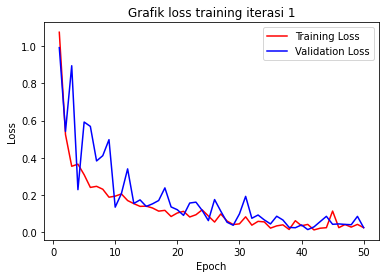

In [10]:
  #plotting
  epochs = range(1, len(history.history['loss'])+1)
  plt.title(f"Grafik loss training iterasi {iterasi}")
  plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
  plt.plot(epochs, history.history['val_loss'], 'b', label='Validation Loss')    
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


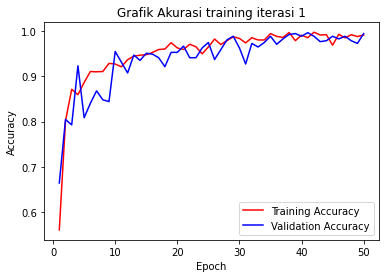

In [11]:
  #plotting
  epochs = range(1, len(history.history['loss'])+1)
  plt.title(f"Grafik Akurasi training iterasi {iterasi}")
  plt.plot(epochs, history.history['Accuracy'], 'r', label='Training Accuracy')
  plt.plot(epochs, history.history['val_Accuracy'], 'b', label='Validation Accuracy')    
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

**Validating** Network

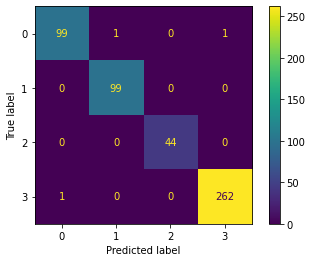

--------
[ 99  99  44 262]
[405 407 463 243]
[1 1 0 1]
[2 0 0 1]
--------
[0.99408284 0.99802761 1.         0.99605523]
[0.98019802 1.         1.         0.99619772]
[0.99753695 0.99754902 1.         0.99590164]
--------
504
1518
3
3
--------
0.9970414201183432
0.9940828402366864
0.9980276134122288


In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from numpy import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, recall_score

validation = model.predict(np_image_list_validation)

predicted_labels = []
correct_labels = []
for i in range (len(validation)):
  predicted_labels.append(np.argmax(validation[i]))

for i in range (len(image_labels_validation)):
  correct_labels.append(np.argmax(image_labels_validation[i]))


confusion_matrix = confusion_matrix(correct_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)  
disp.plot()
plt.show()
print('--------')
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TP)
print(TN)
print(FP)
print(FN)
print('--------')
print(ACC)
print(TPR)
print(TNR)
print('--------')

TP = sum(TP)
TN = sum(TN)
FP = sum(FP)
FN = sum(FN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TP)
print(TN)
print(FP)
print(FN)
print('--------')
print(ACC)
print(TPR)
print(TNR)


**Testing** Network

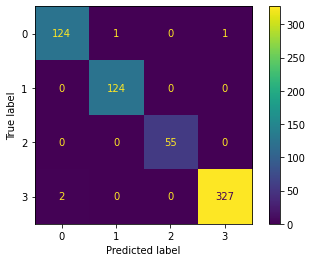

--------
[124 124  55 327]
[506 509 579 304]
[2 1 0 1]
[2 0 0 2]
--------
[0.99369085 0.99842271 1.         0.99526814]
[0.98412698 1.         1.         0.99392097]
[0.99606299 0.99803922 1.         0.99672131]
--------
630
1898
4
4
--------
0.9968454258675079
0.9936908517350158
0.9978969505783386


In [13]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from numpy import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, recall_score

test = model.predict(np_image_list_test)

predicted_labels = []
correct_labels = []
for i in range (len(test)):
  predicted_labels.append(np.argmax(test[i]))

for i in range (len(image_labels_test)):
  correct_labels.append(np.argmax(image_labels_test[i]))


confusion_matrix = confusion_matrix(correct_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)  
disp.plot()
plt.show()
print('--------')
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TP)
print(TN)
print(FP)
print(FN)
print('--------')
print(ACC)
print(TPR)
print(TNR)
print('--------')

TP = sum(TP)
TN = sum(TN)
FP = sum(FP)
FN = sum(FN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TP)
print(TN)
print(FP)
print(FN)
print('--------')
print(ACC)
print(TPR)
print(TNR)

In [14]:
# save the model to disk
#print("[INFO] Saving model...")
# pickle.dump(model,open('cnn_model.pkl', 'wb'))
model.save('/content/fold5.h5')    

In [15]:
#test_img = cv2.imread('/content/datasets/Apple/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG')

#plt.imshow(test_img)
#test_img = test_img / 255
#test_img = np.expand_dims(test_img, axis=0)
#pr=model.predict(test_img)

#print(pr)
#output = label_binarizer.inverse_transform(pr)
#print(output)
